In [84]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from datetime import datetime
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F
import random
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [85]:
import os
from google.colab import drive
drive.mount('/content/gdrive')
folder = '/content/gdrive/My Drive/ML-project'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [86]:
daily = pd.read_csv(folder+ "/Targets/daily_crsp_sanitized.csv", parse_dates=['date'], nrows=100000)

In [87]:
#  Step 1: Prepare Data with lagged returns and categorical encoding

daily['date'] = pd.to_datetime(daily['date'])

# Sort and add lagged returns per PERMNO
daily = daily.sort_values(['PERMNO', 'date'])

# Shift returns to create lagged features; keep NaNs for first few rows
daily['DlyRet_lag1'] = daily.groupby('PERMNO')['DlyRet'].shift(1)
daily['DlyRet_lag5'] = daily.groupby('PERMNO')['DlyRet'].shift(5)

daily['DlyRet_lag1'].fillna(daily['DlyRet_lag1'].mean(), inplace=True)
daily['DlyRet_lag5'].fillna(daily['DlyRet_lag5'].mean(), inplace=True)

# Encode categorical columns for embeddings
for col in ['SICCD', 'NAICS']:
    daily[col] = daily[col].astype('category')
    daily[f'{col}_cat'] = daily[col].cat.codes

# Feature lists
features = ['sprtrn', 'DlyRet_lag1', 'DlyRet_lag5']  # numeric
cat_features = ['SICCD_cat', 'NAICS_cat']            # categorical (encoded)

# Train/test split based on dates (chronological)
unique_dates = np.sort(daily['date'].unique())
n_train = int(len(unique_dates) * 0.75)
train_dates = unique_dates[:n_train]
test_dates = unique_dates[n_train:]

train_df = daily[daily['date'].isin(train_dates)].reset_index(drop=True)
test_df = daily[daily['date'].isin(test_dates)].reset_index(drop=True)

<ipython-input-87-1943dcf3de75>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  daily['DlyRet_lag1'].fillna(daily['DlyRet_lag1'].mean(), inplace=True)
<ipython-input-87-1943dcf3de75>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, 

In [88]:
# Dataset class
class FinancialDataset(Dataset):
    def __init__(self, df, features, cat_features, target_col='DlyRet'):
        self.X_num = df[features].values.astype(np.float32)
        self.X_cat = df[cat_features].values.astype(np.int64)
        self.y = df[target_col].values.astype(np.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X_num[idx], self.X_cat[idx], self.y[idx]

train_dataset = FinancialDataset(train_df, features, cat_features)
test_dataset = FinancialDataset(test_df, features, cat_features)

train_loader = DataLoader(train_dataset, batch_size=1024, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [89]:
class ResidualBlock(nn.Module):
    def __init__(self, dim, dropout_prob=0.3):  # add dropout param
        super().__init__()
        self.fc1 = nn.Linear(dim, dim)
        self.bn1 = nn.BatchNorm1d(dim)
        self.act1 = nn.LeakyReLU(0.1)
        self.dropout1 = nn.Dropout(dropout_prob)  # add dropout

        self.fc2 = nn.Linear(dim, dim)
        self.bn2 = nn.BatchNorm1d(dim)
        self.act2 = nn.LeakyReLU(0.1)
        self.dropout2 = nn.Dropout(dropout_prob)  # add dropout

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.act1(out)
        out = self.dropout1(out)  # apply dropout

        out = self.fc2(out)
        out = self.bn2(out)
        out += residual
        out = self.act2(out)
        out = self.dropout2(out)  # apply dropout
        return out


In [90]:
class ResidualMLP(nn.Module):
    def __init__(self, num_numeric_feats, cat_dims, embedding_dim=8, hidden_dim=64, n_blocks=3, dropout_prob=0.2):
        super().__init__()
        self.embeddings = nn.ModuleList([
            nn.Embedding(cat_dim, embedding_dim) for cat_dim in cat_dims
        ])

        input_dim = num_numeric_feats + embedding_dim * len(cat_dims)
        self.fc_in = nn.Linear(input_dim, hidden_dim)
        self.bn_in = nn.BatchNorm1d(hidden_dim)
        self.act_in = nn.LeakyReLU(0.1)
        self.dropout_in = nn.Dropout(dropout_prob)  # dropout after initial layer

        self.res_blocks = nn.Sequential(
            *[ResidualBlock(hidden_dim, dropout_prob) for _ in range(n_blocks)]
        )

        self.fc_out = nn.Linear(hidden_dim, 1)

    def forward(self, x_num, x_cat):
        embedded = [emb(x_cat[:, i]) for i, emb in enumerate(self.embeddings)]
        x = torch.cat([x_num] + embedded, dim=1)

        x = self.fc_in(x)
        x = self.bn_in(x)
        x = self.act_in(x)
        x = self.dropout_in(x)  # dropout applied here

        x = self.res_blocks(x)
        out = self.fc_out(x).squeeze(-1)
        return out

In [91]:
def sharpe_ratio_loss(y_pred, y_true, eps=1e-6):
    port_returns = y_pred * y_true
    mean = port_returns.mean()
    std = port_returns.std()
    sharpe = mean / (std + eps)
    return -sharpe

In [92]:
# ---- Evaluation function ----
def evaluate_sharpe(model, loader):
    model.eval()
    all_preds = []
    all_y = []
    with torch.no_grad():
        for x_num, x_cat, y in loader:
            preds = model(x_num, x_cat)
            all_preds.append(preds)
            all_y.append(y)

    preds = torch.cat(all_preds)
    y_true = torch.cat(all_y)
    port_returns = preds * y_true
    mean_ret = port_returns.mean().item()
    std_ret = port_returns.std().item()
    sharpe = mean_ret / (std_ret + 1e-8)
    return sharpe


In [93]:
import seaborn as sns

num_numeric_feats = len(features)
cat_dims = [daily[col].nunique() for col in cat_features]

model = ResidualMLP(num_numeric_feats, cat_dims)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Modify train_model to return epoch losses and Sharpe ratios
def train_model(model, train_loader, test_loader, optimizer, epochs= 50):
    train_losses = []
    test_losses = []
    train_sharpes = []
    test_sharpes = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for x_num, x_cat, y in train_loader:
            optimizer.zero_grad()
            outputs = model(x_num, x_cat)
            loss = sharpe_ratio_loss(outputs, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        # Evaluate test loss
        model.eval()
        total_test_loss = 0
        with torch.no_grad():
            for x_num, x_cat, y in test_loader:
                outputs = model(x_num, x_cat)
                loss = sharpe_ratio_loss(outputs, y)
                total_test_loss += loss.item()
        avg_test_loss = total_test_loss / len(test_loader)
        test_losses.append(avg_test_loss)

        # Evaluate Sharpe on train and test set each epoch
        train_sharpe = evaluate_sharpe(model, train_loader)
        test_sharpe = evaluate_sharpe(model, test_loader)
        train_sharpes.append(train_sharpe)
        test_sharpes.append(test_sharpe)

        print(f"Epoch {epoch+1}/{epochs}, Loss (neg Sharpe): {avg_loss:.4f}, Train Sharpe: {train_sharpe:.4f}, Test Sharpe: {test_sharpe:.4f}")

    return train_losses, test_losses, train_sharpes, test_sharpes


# Run training and capture metrics
train_losses, test_losses, train_sharpes, test_sharpes = train_model(model, train_loader, test_loader, optimizer, epochs=50)




Epoch 1/50, Loss (neg Sharpe): -0.0533, Train Sharpe: 0.0726, Test Sharpe: 0.1617
Epoch 2/50, Loss (neg Sharpe): -0.0657, Train Sharpe: 0.0786, Test Sharpe: 0.1629
Epoch 3/50, Loss (neg Sharpe): -0.0736, Train Sharpe: 0.0845, Test Sharpe: 0.1498
Epoch 4/50, Loss (neg Sharpe): -0.0784, Train Sharpe: 0.0932, Test Sharpe: 0.1517
Epoch 5/50, Loss (neg Sharpe): -0.0872, Train Sharpe: 0.1024, Test Sharpe: 0.1379
Epoch 6/50, Loss (neg Sharpe): -0.0890, Train Sharpe: 0.1096, Test Sharpe: 0.1465
Epoch 7/50, Loss (neg Sharpe): -0.0965, Train Sharpe: 0.1159, Test Sharpe: 0.1405
Epoch 8/50, Loss (neg Sharpe): -0.1071, Train Sharpe: 0.1317, Test Sharpe: 0.1338
Epoch 9/50, Loss (neg Sharpe): -0.1193, Train Sharpe: 0.1496, Test Sharpe: 0.1170
Epoch 10/50, Loss (neg Sharpe): -0.1291, Train Sharpe: 0.1634, Test Sharpe: 0.1295
Epoch 11/50, Loss (neg Sharpe): -0.1482, Train Sharpe: 0.1406, Test Sharpe: -0.0095
Epoch 12/50, Loss (neg Sharpe): -0.1681, Train Sharpe: 0.1829, Test Sharpe: 0.1091
Epoch 13/50,

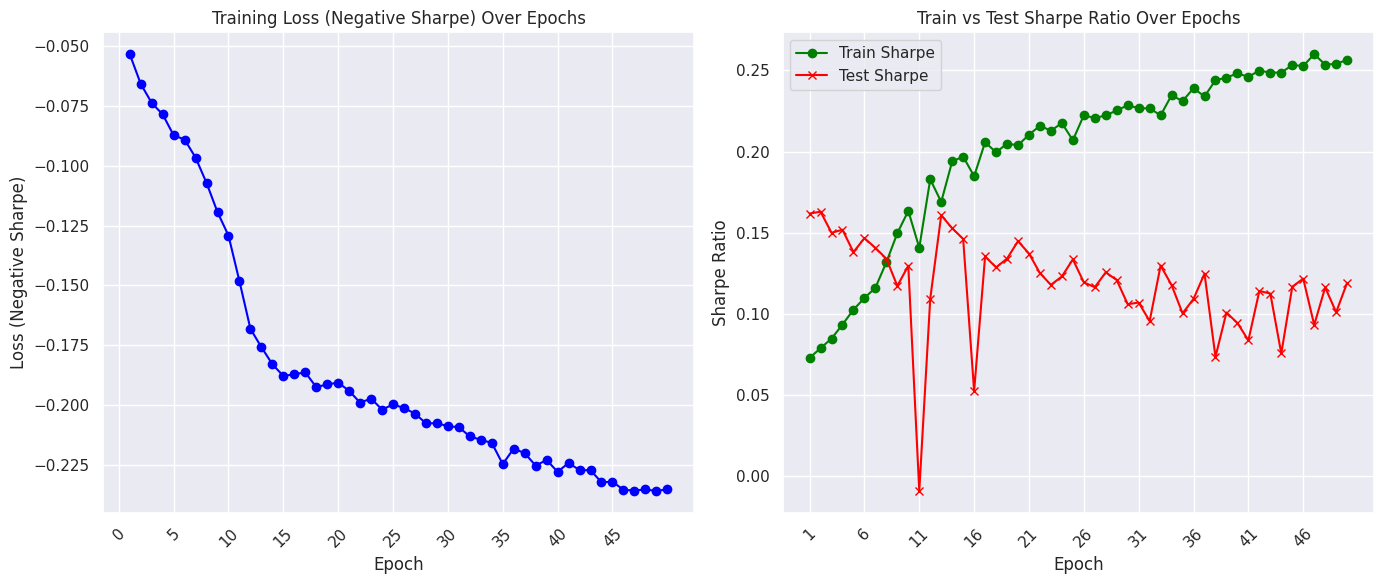

In [94]:
# Plot results
epochs = list(range(1, 51))
sns.set(style="darkgrid")
plt.figure(figsize=(14, 6))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, marker='o', color='blue')
plt.title('Training Loss (Negative Sharpe) Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative Sharpe)')
plt.xticks(ticks=range(0, 50, 5), rotation=45)  # Show ticks every 5 epochs, rotated

# Plot Sharpe ratios
plt.subplot(1, 2, 2)
plt.plot(epochs, train_sharpes, label='Train Sharpe', marker='o', color='green')
plt.plot(epochs, test_sharpes, label='Test Sharpe', marker='x', color='red')
plt.title('Train vs Test Sharpe Ratio Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.xticks(ticks=range(1, 51, 5), rotation=45)  # Same here

plt.tight_layout()
plt.show()


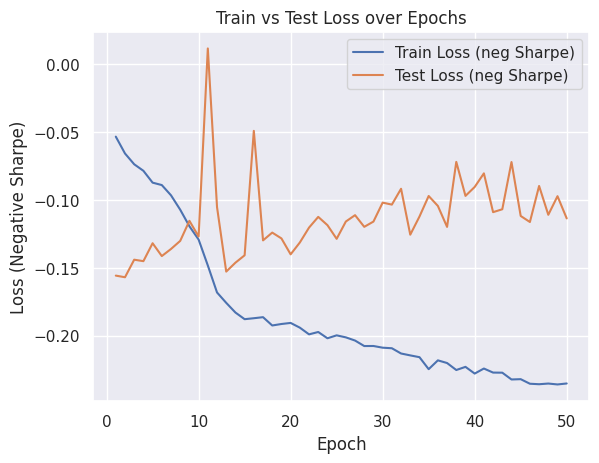

In [95]:
plt.plot(range(1, 51), train_losses, label='Train Loss (neg Sharpe)')
plt.plot(range(1, 51), test_losses, label='Test Loss (neg Sharpe)')
plt.xlabel('Epoch')
plt.ylabel('Loss (Negative Sharpe)')
plt.title('Train vs Test Loss over Epochs')
plt.legend()
plt.grid(True)
plt.show()